# Análisis Exploratorio de Datos (EDA) – Instagram Analytics Dataset

**Autor:** _Carlos Checa Moreno_  

En este notebook realizo un análisis exploratorio inicial (EDA) del dataset
**"[Maddison Project Dataset 2020 Raw](https://www.kaggle.com/datasets/mathurinache/maddison-project-dataset-2020-raw)"** obtenido de Kaggle.

El objetivo es:

1. Cargar el dataset.
2. Explorar su estructura y calidad.
3. Realizar tareas básicas de limpieza y normalización.
4. Generar visualizaciones sencillas que ayuden a entender los datos.
5. Resumir las conclusiones principales del análisis exploratorio.

---


# 1. Cargar el Dataset.

Para encontrar un dataset adecuado para esta primera práctica, he buscado "raw data" en Kaggle y he podido encontrar el dataset Maddison Project Dataset 2020 Raw. Este dataset nos presenta varios retos como valores nulos, fechas, no existe una variable indentificadora por sí misma y tenemos columnas que nos dan la misma información. Trataré todos estos problemas en los siguientes puntos.

A parte, para que suponga un mayor reto, añadiré registros duplicados manualmente los cuales tendrán también valores faltantes. Obviamente esto se realizará únicamente con fines académicos para poner en práctica todos los conocimientos posibles adquiridos en estas semanas del máster.

Empezando con el código, cargo el dataset directamente de Kaggle.

In [26]:
# Imports para acceder al dataset y cargarlo en un dataframe
import os
import pandas as pd

## 1.1. Importar Dataset

### 1.1.1. Cargar el dataset desde Kaggle

In [27]:
import kagglehub

path = kagglehub.dataset_download("mathurinache/maddison-project-dataset-2020-raw")
print("Ruta de los ficheros del dataset:", path)
os.listdir(path)

# Cargo el dataset en un dataframe de pandas
nombre_fichero = "Maddison Project Dataset 2020 Raw.csv"
ruta_csv = os.path.join(path, nombre_fichero)
df = pd.read_csv(ruta_csv)

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ruta de los ficheros del dataset: C:\Users\carlo\.cache\kagglehub\datasets\mathurinache\maddison-project-dataset-2020-raw\versions\1


### 1.1.2. Cargar el dataset desde la carpeta

In [51]:
ruta_csv = "../data/dataset.csv"
df = pd.read_csv(ruta_csv)

## 1.2. Revisar dimensiones y primeras filas

El dataset está compuesto por las siguientes variables:
*   countrycode: Código abreviado (3 letras) que identifica al país.
*   country: Nombre del país al que pertenece la observación.
*   year: Año al que se refiere el dato económico y demográfico.
*   gdppc: Producto interior bruto por persona.
*   pop: Población total del país en ese año.

In [28]:
print("Dimensiones del dataframe:", df.shape)
df.head()

Dimensiones del dataframe: (21682, 5)


,countrycode,country,year,gdppc,pop
0,AFG,Afghanistan,1820,NaN,3 280
1,AFG,Afghanistan,1870,NaN,4 207
2,AFG,Afghanistan,1913,NaN,5 730
3,AFG,Afghanistan,1950,1 156,8 150
4,AFG,Afghanistan,1951,1 170,8 284


## 1.3. Inspeccionar tipos de datos

In [52]:
print(df.dtypes, "\n")
df.info()


countrycode    object
country        object
year            int64
gdppc          object
pop            object
dtype: object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21682 entries, 0 to 21681
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   countrycode  21682 non-null  object
 1   country      21682 non-null  object
 2   year         21682 non-null  int64 
 3   gdppc        19706 non-null  object
 4   pop          17199 non-null  object
dtypes: int64(1), object(4)
memory usage: 847.1+ KB


Gracias a esta información sabemos que tenemos 21 682 filas. Las columnas de PIB per cápita (gdppc) y población (pop) tienen valores faltantes (en el siguiente punto abordaremos más en profundidad este tema) y además están como object, así que será necesario convertirlos a variables numéricas para analizarlas adecuadamente.

# 2. Explorar su estructura y calidad.

Antes de empezar a corregir el dataset, voy a introducir algunos registros duplicados con valores faltantes. Esto lo haré unicamente con fines académicos para poder aplicar todos los conocimientos posibles adquiridos durante estas primeras semanas del máster. 

De base este dataset sí contiene valores faltantes, pero no duplicados. De ahí esta decisión de aumentar la dificultad a la hora de formatear el dataset.

In [53]:
import numpy as np

n_dup = min(500, len(df)) 
df_dup = df.sample(n=n_dup, replace=False).copy()
cols_objetivo = df_dup.columns
col_aleatoria_por_fila = np.random.choice(cols_objetivo, size=len(df_dup))
for i, col in enumerate(col_aleatoria_por_fila):
    idx = df_dup.index[i]
    df_dup.loc[idx, col] = np.nan
df = pd.concat([df, df_dup], ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22182 entries, 0 to 22181
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countrycode  22086 non-null  object 
 1   country      22078 non-null  object 
 2   year         22087 non-null  float64
 3   gdppc        20072 non-null  object 
 4   pop          17520 non-null  object 
dtypes: float64(1), object(4)
memory usage: 866.6+ KB


Aquí es interesante observar como la columna year cambia del tipo int64 a float64. Esto sucede porque el tipo int64 no admite NaN, por esto pandas convierte este tipo a float para poder guardas el Nan. 

En otras palabras, como vimos en el punto 1.3 la columna year no tenía valores faltantes. Al insertar valores faltantes en esta dimensión, es necesario cambiar el dominio de dicha variable par que admita el valor faltante.

## 2.1. Corrección de tipos.

Primero, cambio los tipos de las variables gdppc y pop, que deben ser numéricas. También hay que tener en cuenta que como separador de miles se está usando el espacio.

In [49]:
df['gdppc'] = df['gdppc'].str.replace('\xa0',"").astype('float32')
df['pop'] = df['pop'].str.replace('\xa0',"").astype('float32')
print(df.dtypes)

countrycode     object
country         object
year           float64
gdppc          float32
pop            float32
dtype: object


## 2.2. Valores nulos.

In [7]:
# Valores nulos por columna: conteo y porcentaje
null_counts = df.isna().sum()
null_percent = df.isna().mean() * 100

valores_nulos = pd.DataFrame({
    "n_nulos": null_counts,
    "porcentaje_nulos": null_percent.round(2)
})

valores_nulos

,n_nulos,porcentaje_nulos
countrycode,0,0.00
country,0,0.00
year,0,0.00
gdppc,1976,9.11
pop,4483,20.68


## 2.2. Duplicados.


In [8]:
# Número de filas duplicadas considerando todas las columnas
num_duplicados = df.duplicated().sum()
print("Número de filas duplicadas:", num_duplicados)

# (Opcional) ver algunas filas duplicadas
df_duplicados = df[df.duplicated(keep=False)]
df_duplicados.head()


Número de filas duplicadas: 0


,countrycode,country,year,gdppc,pop


## 2.3. Rango de las variables.

In [9]:
# Estadísticos básicos de las variables numéricas
desc_num = df.describe().T

# Ver mínimo, máximo y rango
rango_variables = desc_num[["min", "max"]].assign(rango=desc_num["max"] - desc_num["min"])
rango_variables


,min,max,rango
year,1.0,2018.0,2017.0


## 2.4. Incoherencias.

In [15]:
# Aseguramos columnas numéricas (lo no numérico -> NaN)
pop_num   = pd.to_numeric(df["pop"],   errors="coerce")
gdppc_num = pd.to_numeric(df["gdppc"], errors="coerce")
year_num  = pd.to_numeric(df["year"],  errors="coerce")

# 1) Población incoherente (<= 0, pero solo donde haya dato)
cond_pop_mala = pop_num.notna() & (pop_num <= 0)

# 2) PIB per cápita incoherente (<= 0, pero solo donde haya dato)
cond_gdppc_malo = gdppc_num.notna() & (gdppc_num <= 0)

# 3) Año incoherente (negativo, pero solo donde haya dato)
cond_year_malo = year_num.notna() & (year_num < 0)

# 4) country NO debería ser un número (NaN no cuenta como incoherencia)
country_num = pd.to_numeric(df["country"], errors="coerce")
cond_country_numerico = df["country"].notna() & country_num.notna()

# 5) countrycode debe ser 3 letras mayúsculas (NaN no cuenta como incoherencia)
valid_cc = df["countrycode"].astype("string").str.match(r"^[A-Z]{3}$", na=False)
cond_countrycode_malo = df["countrycode"].notna() & ~valid_cc

print("Filas con pop <= 0:", cond_pop_mala.sum())
print("Filas con gdppc <= 0:", cond_gdppc_malo.sum())
print("Filas con year < 0:", cond_year_malo.sum())
print("Filas con country numérico:", cond_country_numerico.sum())
print("Filas con countrycode no válido:", cond_countrycode_malo.sum())

# DataFrame con todas las filas incoherentes
incoherencias_maddison = df[
    cond_pop_mala
    | cond_gdppc_malo
    | cond_year_malo
    | cond_country_numerico
    | cond_countrycode_malo
]

incoherencias_maddison.head()


Filas con pop <= 0: 0
Filas con gdppc <= 0: 2
Filas con year < 0: 0
Filas con country numérico: 0
Filas con countrycode no válido: 0


,countrycode,country,year,gdppc,pop
293,ARE,United Arab Emirates,1991,0,1 935
294,ARE,United Arab Emirates,1992,0,2 050


## 2.5. Distribución inicial de columnas.

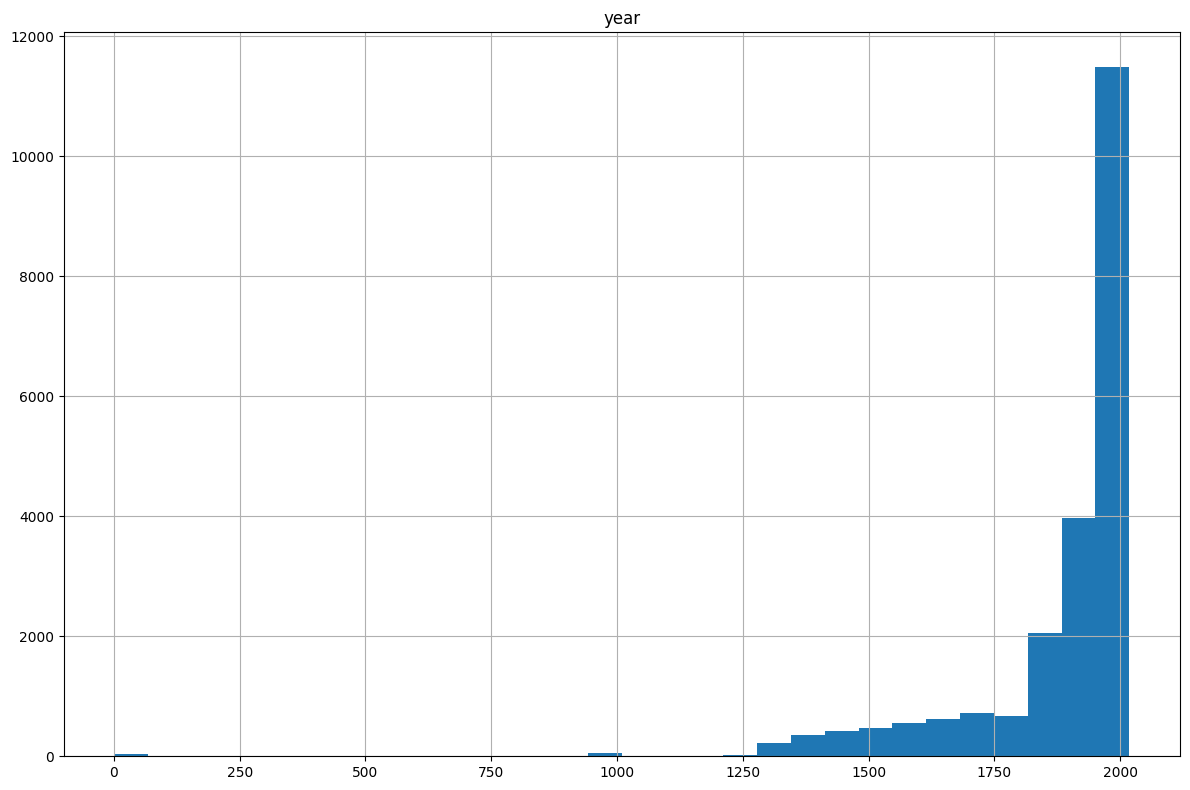

In [10]:
import matplotlib.pyplot as plt

# Distribución de columnas numéricas (histogramas)
df.select_dtypes(include="number").hist(figsize=(12, 8), bins=30)
plt.tight_layout()


In [ ]:
# Distribución de columnas categóricas (frecuencias)
cat_cols = df.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    print(f"\nDistribución de la columna: {col}")
    print(df[col].value_counts().head(10))



Distribución de la columna: countrycode
countrycode
GBR    769
SWE    721
ITA    711
FRA    711
NLD    667
POL    581
PRT    492
PER    426
MEX    374
ZAF    282
Name: count, dtype: int64

Distribución de la columna: country
country
United Kingdom    769
Sweden            721
Italy             711
France            711
Netherlands       667
Poland            581
Portugal          492
Peru              426
Mexico            374
South Africa      282
Name: count, dtype: int64

Distribución de la columna: gdppc
gdppc
1 643    59
1 710    56
1 677    50
1 659    49
1 728    47
1 745    43
1 694    28
1 610    25
1 779    24
1 795    23
Name: count, dtype: int64

Distribución de la columna: pop
pop
1 000      22
74         16
2 000      16
800        16
500        14
73         14
300        13
72         12
412 000    11
70         11
Name: count, dtype: int64
